In [8]:
#--------- IMPORTING ALL LIBRARIES------------------

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

In [9]:
def compute_mean_std(img_dir):
    transform = transforms.ToTensor()
    means, stds = [], []
    for i in sorted(os.listdir(img_dir)):
        img = Image.open(os.path.join(img_dir, i)).convert("RGB")
        tensors = transform(img)
        means.append(torch.mean(tensors, dim = (1, 2)))
        
        stds.append(torch.std(tensors, dim = (1, 2)))
    means = torch.stack(means).mean(0) #mean along 0 dim
    stds = torch.stack(stds).mean(0)
    return means.tolist(), stds.tolist()

image_path = "/kaggle/input/retinal-vessel-segmentation/DRIVE/training/images"
mean , std = compute_mean_std(image_path)   
print(f"Mean: {mean}, Std: {std}")

Mean: [0.49740028381347656, 0.27064886689186096, 0.16243760287761688], Std: [0.3316500186920166, 0.17835408449172974, 0.09872565418481827]


In [10]:
def crop(img, size):
    width , height = img.size
    #todo: handle case where size is less than width or height
    delta0 = size - width
    delta1 = size - height
    padding = (0, 0, delta0, delta1)  
    return transforms.functional.pad(img, padding, fill=0)

class RetinalDataset(Dataset):
    def __init__(self, img_dir, mask_dir, fov_path, image_transform = None, mask_transform = None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.fov_path = fov_path
        self.image_lists = sorted(os.listdir(img_dir))
        self.mask_lists = sorted(os.listdir(mask_dir))
        self.fov = sorted(os.listdir(fov_path))
        self.image_transform = image_transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.image_lists)

    def __getitem__(self, idx):
        image = Image.open(os.path.join(self.img_dir, self.image_lists[idx])).convert("RGB")
        
        mask = Image.open(os.path.join(self.mask_dir, self.mask_lists[idx])).convert("L") #convert to grayscale
        fov = Image.open(os.path.join(self.fov_path, self.fov[idx])).convert("L") #convert to grayscale
        crop_image = crop(image, size = 592) #since model expects spacial dim of 592 
        mask_crop = crop(mask, size = 592)
        fov_crop = crop(fov, size = 592)
        image = self.image_transform(crop_image)
        mask = self.mask_transform(mask_crop)
        fov = self.mask_transform(fov_crop) #same transform to fov

        #image and masks are converted to tensors by transform
        mask = (mask > 0.5).float() #creating a binary mask
        fov = (fov > 0.5).float() #creating a binary mask
        # print(f"{mask.size()}, {image.size()}")
        return image, mask, fov

img_transform = transforms.Compose([
    # transforms.Resize((592, 592)), #doing zero padding instead of resizing
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.49740028381347656, 0.27064886689186096, 0.16243760287761688], std = [0.3316500186920166, 0.17835408449172974, 0.09872565418481827])
])

msk_transform = transforms.Compose([
    transforms.ToTensor()
])


image_path = "/kaggle/input/retinal-vessel-segmentation/DRIVE/training/images"
mask_path = "/kaggle/input/retinal-vessel-segmentation/DRIVE/training/1st_manual"
fov_path = "/kaggle/input/retinal-vessel-segmentation/DRIVE/training/mask"



train_data = RetinalDataset(image_path, mask_path, fov_path, image_transform = img_transform, mask_transform = msk_transform)

indices = list(range(len(train_data)))  # [0,1,2,...,19]
train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42)
train_dataset = Subset(train_data, train_idx)  # 16 images
val_dataset = Subset(train_data, val_idx)      # 4 images

train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)   # For training
val_loader = DataLoader(val_dataset, batch_size=5, shuffle=False)    

In [11]:
""""
This is implementation of SA_Unetv2 that uses both encoder and decoder feature for attention not just add attention in the bottleneck as done in SA-Unet

You can find original paper here -> https://arxiv.org/html/2509.11774v1

"""

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)  # Average across channels
        max_out, _ = torch.max(x, dim=1, keepdim=True)  # Max across channels
        combined = torch.cat([avg_out, max_out], dim=1)  # Concat: (B, 2, H, W)
        attention_map = self.sigmoid(self.conv(combined))  # (B, 1, H, W)
        return x * attention_map
        
class CrossScaleSpatialAttention(nn.Module):
    def __init__(self):
        super().__init__()
        # as mentioned in the paper: apply avgpooling on feature maps of encoder and decoder separately then pass it to 7*7 convolution followed by sigmoid
        self.sigmoid = nn.Sigmoid()
        self.conv = nn.Conv2d(2, 1, kernel_size=7, padding = 3)

    def forward(self, encoder_feature, decoder_feature):
        if encoder_feature.shape[2:] != decoder_feature.shape[2:]:
            decoder_feature = F.interpolate(decoder_feature, size=encoder_feature.shape[2:], mode='bilinear', align_corners=False)
        en_f = torch.mean(encoder_feature, dim=1, keepdim=True)
        de_f = torch.mean(decoder_feature, dim=1, keepdim=True)
        #now concatenate
        features = torch.cat([en_f, de_f], dim = 1)
        attention = self.sigmoid(self.conv(features))

        return encoder_feature * attention

def double_conv(in_ch, out_ch):
    # 2 convolution layers of size 3*3
    conv = nn.Sequential(
        nn.Conv2d(in_ch, out_ch, kernel_size=3, padding = 1),
        nn.Dropout(p = 0.15), #add some probability
        nn.GroupNorm(8, out_ch),
        nn.SiLU(),
        nn.Conv2d(out_ch, out_ch, kernel_size=3, padding = 1),
        nn.Dropout(p = 0.15),
        nn.GroupNorm(8, out_ch),
        nn.SiLU()
    )
    return conv

# def crop_image(tensor, target):
#     #reduce the tensor to target size
#     target_size = target.size()[2]
#     tensor_size = tensor.size()[2]
#     delta = tensor_size - target_size
#     delta = delta // 2
#     return tensor[:, :, delta: tensor_size - delta, delta: tensor_size- delta]

class SAUnetv2(nn.Module):
    def __init__(self, input_channel = 3, output_channel = 1):
        super().__init__()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv_1 = double_conv(input_channel, 16)
        self.conv_2 = double_conv(16, 32)
        self.conv_3 = double_conv(32, 48)       
        self.conv_4 = double_conv(48, 64)

        self.bottleneck = double_conv(64, 64) #bottleneck
        #applying spatial attention to bottleneck
        self.spatial_attention = SpatialAttention(kernel_size = 7)
        self.csa4 = CrossScaleSpatialAttention()
        self.csa3 = CrossScaleSpatialAttention()
        self.csa2 = CrossScaleSpatialAttention()
        self.csa1 = CrossScaleSpatialAttention()

        self.up4 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=2, stride=2)
        self.up_conv4 = double_conv(128, 64)
        
        self.up3 = nn.ConvTranspose2d(in_channels=64, out_channels=48, kernel_size=2, stride=2)
        self.up_conv3 = double_conv(96, 48)

        self.up2 = nn.ConvTranspose2d(in_channels=48, out_channels=32, kernel_size=2, stride=2)
        self.up_conv2 = double_conv(64, 32)

        self.up1 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=2, stride=2)
        self.up_conv1 = double_conv(32, 16)

        self.output = nn.Conv2d(in_channels=16, out_channels=output_channel, kernel_size=1)
    
    def forward(self, image):
        #encoder
        x1 = self.conv_1(image)
        x2 = self.maxpool(x1)
        x3 = self.conv_2(x2)
        x4 = self.maxpool(x3)
        x5 = self.conv_3(x4)
        x6 = self.maxpool(x5)
        x7 = self.conv_4(x6)
        x8 = self.maxpool(x7)
        x9 = self.bottleneck(x8)
        bottleneck = self.spatial_attention(x9)

        x = self.up4(bottleneck)  
        #we are croping to make the dims compatible in order to add as given in the architecture
        d4_attention = self.csa4(x7, x)
        x = self.up_conv4(torch.cat([x, d4_attention], 1))

        x = self.up3(x)  
    
        d3_attention = self.csa3(x5, x)
        x = self.up_conv3(torch.cat([x, d3_attention], 1))

        x = self.up2(x) 
 
        d2_attention= self.csa2(x3, x)
        x = self.up_conv2(torch.cat([x, d2_attention], 1))

        x = self.up1(x)  
        d1_attention= self.csa1(x1, x)
        x = self.up_conv1(torch.cat([x, d1_attention], 1))
        
        x = self.output(x) # another option is to pass it into sigmoid but then use BCEloss, using BCEwithlogitsloss for numerical stability
        return x
       
model = SAUnetv2()
# print(model)
# # #batchsize , channel , height, width
# image = torch.rand((1, 3, 592, 592))
# print(model(image))

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

## loss function

"""
Implement compound loss -> SAUnetv2 adopts weighted Binary cross entropy plus Matthews Correlation Coefficient (MCC) loss to improve robustness to class imbalance.
"""
def calculate_mcc(probab, target):
    eps = 1e-7
    tp = torch.sum(probab * target)
    tn = torch.sum((1 - target) * (1 - probab))
    fp = torch.sum((1-target) * probab)
    fn = torch.sum(target * (1 - probab))
    numerator = (tp * tn) - (fp * fn)
    denominator = torch.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn) + eps)
    mcc = numerator / denominator
    return 1 - mcc
    
def compound_loss(logits, target):
    lambda1, lambda2 = 0.5, 0.5
    if(logits.size() != target.size()):
        print("Size mismatch for logits and target")
    else:
        bce = nn.BCEWithLogitsLoss()(logits, target)
        #MCC needs probability
        probab = torch.sigmoid(logits)
        mcc = calculate_mcc(probab, target)

    return (lambda1 * bce + lambda2 * mcc)

## optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

## training loop
for epoch in range(100):
    model.train()
    total_loss = 0
    for images, mask, _ in train_loader:
        images, mask = images.to(device), mask.to(device)
        output = model(images)
        # print(output.size())
        loss = compound_loss(output, mask)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss/len(train_loader)
    print(f"Epoch {epoch + 1}, Loss: {avg_loss}")
    

cuda
Epoch 1, Loss: 0.8307511806488037
Epoch 2, Loss: 0.7751443833112717
Epoch 3, Loss: 0.7464163154363632
Epoch 4, Loss: 0.7251140475273132
Epoch 5, Loss: 0.7031594663858414
Epoch 6, Loss: 0.6763004660606384
Epoch 7, Loss: 0.6530586332082748
Epoch 8, Loss: 0.6349066495895386
Epoch 9, Loss: 0.6178855895996094
Epoch 10, Loss: 0.5977156460285187
Epoch 11, Loss: 0.5815683752298355
Epoch 12, Loss: 0.5747092664241791
Epoch 13, Loss: 0.5597759187221527
Epoch 14, Loss: 0.5533780306577682
Epoch 15, Loss: 0.5393782258033752
Epoch 16, Loss: 0.5279027819633484
Epoch 17, Loss: 0.5196871757507324
Epoch 18, Loss: 0.5053345337510109
Epoch 19, Loss: 0.4992155283689499
Epoch 20, Loss: 0.4905829280614853
Epoch 21, Loss: 0.4768727421760559
Epoch 22, Loss: 0.4676511660218239
Epoch 23, Loss: 0.46036212146282196
Epoch 24, Loss: 0.45272886008024216
Epoch 25, Loss: 0.44319377839565277
Epoch 26, Loss: 0.4339545890688896
Epoch 27, Loss: 0.4378361105918884
Epoch 28, Loss: 0.42637694627046585
Epoch 29, Loss: 0.41

In [13]:
import torch

def evaluate_metrics(pred_binary, target, fov):
    """
    pred_binary: predicted binary mask (B,1,H,W)
    target: ground truth vessel mask (B,1,H,W)
    fov: FOV mask (B,1,H,W), only evaluate inside white circle
    """

    # flatten all to 1D inside FOV
    pred = pred_binary[fov > 0.5].view(-1)
    true = target[fov > 0.5].view(-1)

    # counts
    TP = torch.sum((pred == 1) & (true == 1)).float()
    TN = torch.sum((pred == 0) & (true == 0)).float()
    FP = torch.sum((pred == 1) & (true == 0)).float()
    FN = torch.sum((pred == 0) & (true == 1)).float()

    # metrics
    dice = (2 * TP) / (2 * TP + FP + FN + 1e-7)
    iou = TP / (TP + FP + FN + 1e-7)
    sensitivity = TP / (TP + FN + 1e-7)   # recall
    specificity = TN / (TN + FP + 1e-7)
    accuracy = (TP + TN) / (TP + TN + FP + FN + 1e-7)
    
    return {
        "Dice": dice.item(),
        "IoU": iou.item(),
        "Sensitivity": sensitivity.item(),
        "Specificity": specificity.item(),
        "Accuracy": accuracy.item()
    }


Metrics: {'Dice': 0.824762761592865, 'IoU': 0.701784074306488, 'Sensitivity': 0.8920486569404602, 'Specificity': 0.966742992401123, 'Accuracy': 0.9585815668106079}


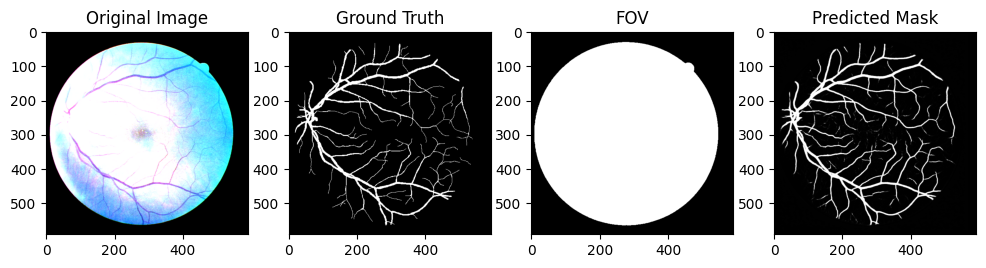

Metrics: {'Dice': 0.8089938759803772, 'IoU': 0.6792525053024292, 'Sensitivity': 0.8705270886421204, 'Specificity': 0.9594481587409973, 'Accuracy': 0.9482548236846924}


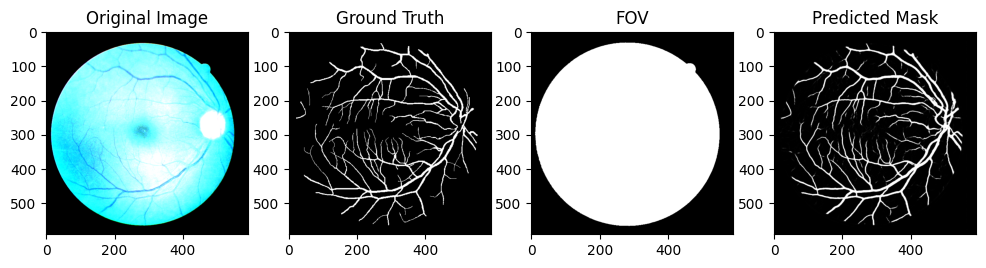

Metrics: {'Dice': 0.837229311466217, 'IoU': 0.7200295925140381, 'Sensitivity': 0.813956081867218, 'Specificity': 0.9755347967147827, 'Accuracy': 0.9500169157981873}


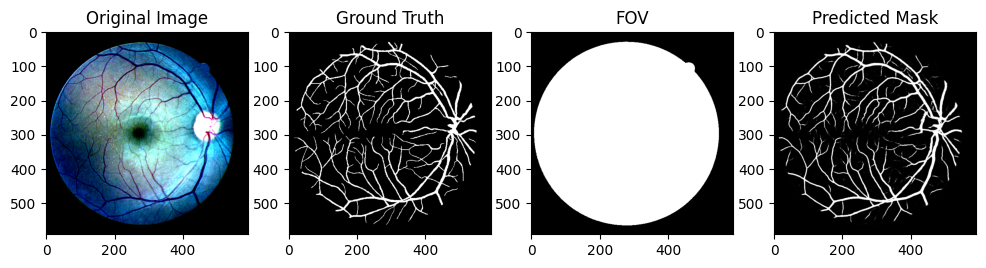

Metrics: {'Dice': 0.8067921996116638, 'IoU': 0.6761540174484253, 'Sensitivity': 0.8179194927215576, 'Specificity': 0.9684262871742249, 'Accuracy': 0.9487276077270508}


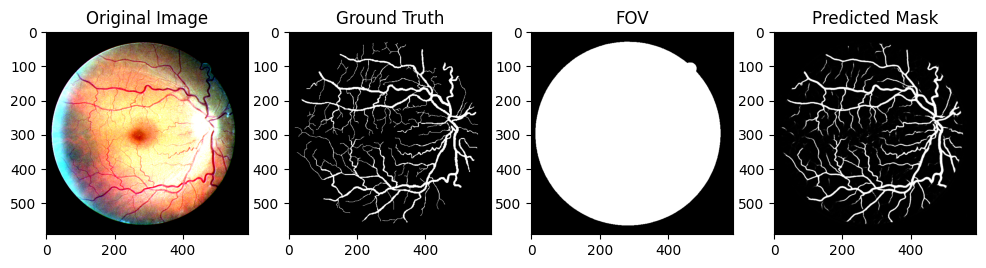

In [14]:
#----------- Model is trained on ground truth masks provided (vessel mask) and evaluated on FOV (field of view) given in DRIVE --------------
#-------- Used 20% of images from the training data for validation, now evaluating on valid dataset

import numpy as np
model.eval()
with torch.no_grad():
    for i in range(len(val_dataset)):  # Show 3 sample predictions
        image, mask, fov = val_dataset[i]

        image = image.unsqueeze(0).to(device)
        mask = mask.squeeze().cpu()
        fov = fov.squeeze().cpu()
        pred = model(image)
        # loss = compound_loss(pred, mask)
        image_show = image.squeeze(0).permute(1,2,0).cpu()
        pred_show = torch.sigmoid(pred).squeeze().cpu() #predictions 
        pred_binary = (pred_show > 0.5).float()
        ## pass to metrics evaluation
        metric = evaluate_metrics(pred_binary, mask, fov)
        print(f"Metrics: {metric}")
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 4, 1)
        plt.imshow(image_show)
        plt.title("Original Image")

        plt.subplot(1, 4, 2)
        plt.imshow(mask, cmap='gray')
        plt.title("Ground Truth")
        
        plt.subplot(1, 4, 3)
        plt.imshow(fov, cmap='gray')
        plt.title("FOV")
        
        plt.subplot(1, 4, 4)
        
        plt.imshow(pred_show, cmap='gray')
        plt.title("Predicted Mask")

        plt.show()
